Actual Firing Rate (Hz): 19.84


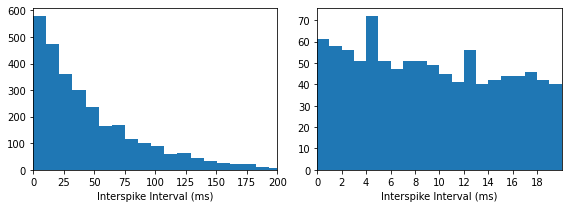

In [1]:
import pytest
import numpy as np
import os
from matplotlib import pyplot as plt
import warnings

from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.utils.reports.spike_trains import SpikeTrains

def plot_isi(psg):
    df = psg.to_dataframe()
    isi = np.empty([0])
    for n in psg.node_ids():
        spk_times = df[df['node_ids']==n]['timestamps']
        isi = np.append(isi, np.diff(np.array(spk_times)))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
    ax[0].hist(isi, bins=40)
    ax[0].set_xlim((0, 200))
    ax[0].set_xlabel('Interspike Interval (ms)')
    edges = np.arange(0,22,1)
    ax[1].hist(isi, bins=edges)
    ax[1].set_xlim((0, 20))
    ax[1].set_xlabel('Interspike Interval (ms)')
    ax[1].set_xticks(np.arange(0,20,2))
    fig.tight_layout()
    
start_time = 0.0
end_time = 3.0
nodes = range(50)

psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=20.0, times=(start_time, end_time))
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

### Now we add a 2 ms absolute refractory period and notice an effect on the ISI histogram:

/home/ping/bmtk_change/bmtk/bmtk/utils/reports/spike_trains/spike_trains.py:211: UserWarning: When using refractory periods, the actual firing rate (19.673333333333332 spk/s) may be less than the desired firing rate (20.870956023640648 spk/s), particularly for high rates, and saturates at 1/abs_ref. See also GammaSpikeGenerator for more exact firing rates with refractory periods.
  warnings.warn(str)


Actual Firing Rate (Hz): 19.673333333333332


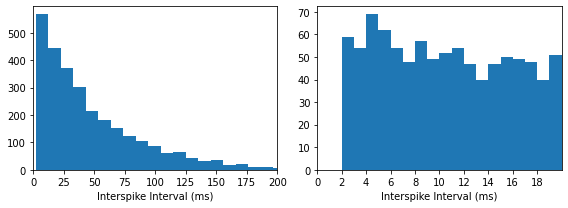

In [2]:
psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=20.0, times=(start_time, end_time), abs_ref=0.002)
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

### Now let's add a relative refractory period that decays exponentially with a time constant of 3 ms, starting from after the absolute refractory period.

/home/ping/bmtk_change/bmtk/bmtk/utils/reports/spike_trains/spike_trains.py:211: UserWarning: When using refractory periods, the actual firing rate (20.14666666666667 spk/s) may be less than the desired firing rate (22.274151349214662 spk/s), particularly for high rates, and saturates at 1/abs_ref. See also GammaSpikeGenerator for more exact firing rates with refractory periods.
  warnings.warn(str)


Actual Firing Rate (Hz): 20.14666666666667


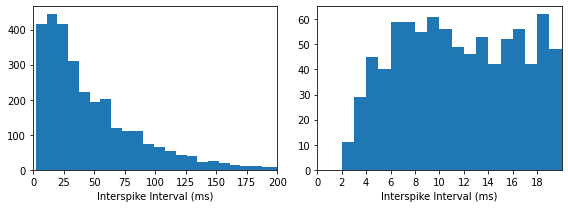

In [3]:
psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=20.0, times=(start_time, end_time), abs_ref=0.002, tau_ref=0.003)
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

### Adding the refractory period reduces the effective firing rate, particularly for high rates - this is now corrected for

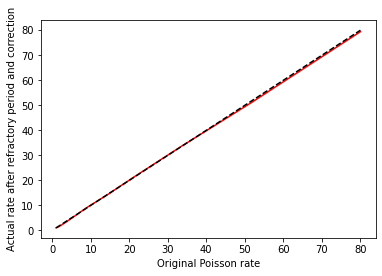

In [5]:
rates = np.logspace(0,np.log10(80),11)
fr_list = []

for fr in rates:
    psg = PoissonSpikeGenerator(population='test', seed=200)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        psg.add(node_ids=nodes, firing_rate=fr, times=(start_time, end_time), abs_ref=0.002, tau_ref=0.003)
    fr_list.append(psg.n_spikes()/(end_time-start_time)/len(nodes))

plt.plot(rates,fr_list,'r')
plt.plot(rates,rates,'k--')
plt.xlabel('Original Poisson rate')
plt.ylabel('Actual rate after refractory period and correction')
plt.show()


In [6]:
psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=100.0, times=(start_time, end_time), abs_ref=0.002, tau_ref=0.003)
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

ValueError: Cannot achieve firing rate above 86.83679244433704 with these absolute and relative refractory properties

In [7]:
# Just for testing of handling of invalid inputs

psg = PoissonSpikeGenerator(population='test', seed=100)
psg.add(node_ids=nodes, firing_rate=20.0, times=(start_time, end_time), abs_ref=0.002, tau_ref=-3)

ValueError: Refractory period time constant (sec) cannot be negative.

In [9]:
psg = PoissonSpikeGenerator(population='test', seed=100)
psg.add(node_ids=nodes, firing_rate=20.0, times=(start_time, end_time), abs_ref=-0.002, tau_ref=1)

ValueError: Absolute refractory period (sec) cannot be negative.

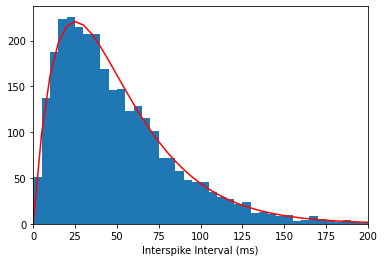

Actual Firing Rate (Hz): 20.06


In [10]:
# Testing gamma spike generator created using every kth spike from the Poisson train
# Based on David Heeger reference
# ISI values must be positive
# For this method, k (the shape parameter) must be an integer, which corresponds to the special case of an Erlang distribution

k = 2   # Can also try 3,4,5, etc. other positive natural integers
psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=20.0*k, times=(start_time, end_time))
df = psg.to_dataframe()
isi = np.empty([0])

n_spk = 0
for n in psg.node_ids():
    spk_times = df[df['node_ids']==n]['timestamps']
    spk_times = spk_times[0:len(spk_times):k]
    isi = np.append(isi, np.diff(np.array(spk_times)))
    n_spk+=len(spk_times)

fig, ax = plt.subplots(1,1)
binsize = 5
bin_list = np.arange(0,202,binsize)
ax.hist(isi, bins=bin_list)
ax.set_xlim((0, 200))
ax.set_xlabel('Interspike Interval (ms)')
fr = 20.0
x = np.arange(0,1000,binsize)
gamma_dist2 = ((k*fr)**k) * ((x/1000)**(k-1)) * np.exp(-k*fr*(x/1000))/np.math.factorial(k-1)
ax.plot(x,gamma_dist2*fr*(end_time-start_time)*len(psg.node_ids())*(binsize/1000),'r-')
plt.show()

actual_fr = n_spk/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')


In [11]:
# Check distribution normalization
sum(gamma_dist2*binsize/1000)

# Number of spikes
psg.n_spikes()

# Number of intervals
len(isi)

#n_spk

sum(gamma_dist2*fr*(end_time-start_time)*len(psg.node_ids())*binsize/1000)

2990.019968298356

Actual Firing Rate (Hz): 20.340388929029967


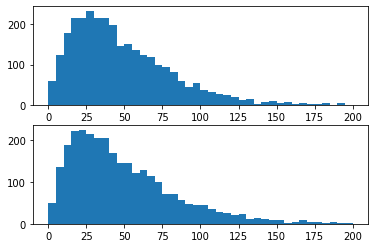

In [12]:
from scipy.stats import gamma
a = 2
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)

fig, ax = plt.subplots(2)
ax[0].hist(r*1000, bins=bin_list)
ax[1].hist(isi, bins=bin_list)   # Compare to preceding method

actual_fr = 3000/(np.sum(r))
print(f'Actual Firing Rate (Hz): {actual_fr}')

Text(110, 192.78, 'Shape parameter = 1.9')

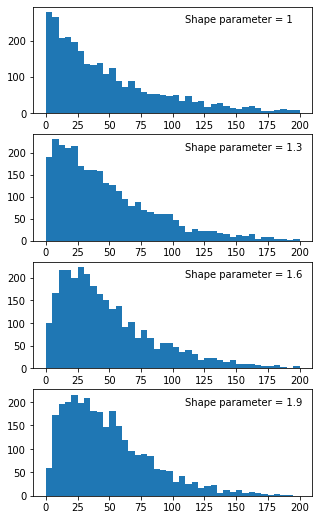

In [13]:
# More general approach for non-discretized a (i.e., k)
# 'a' is the shape parameter which controls the shape of the ISI distribution
# Larger values of ''a'' have slower recovery.

from scipy.stats import gamma
a = 1 # Exponential, i.e., Poisson process for a = 1 
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)

fig, ax = plt.subplots(4, figsize =(5,9))
ax[0].hist(r*1000, bins=bin_list)
yl = ax[0].get_ylim()
ax[0].text(110, 0.85*yl[1], 'Shape parameter = {shape}'.format(shape = a))

a = 1.3
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)
ax[1].hist(r*1000, bins=bin_list)
yl = ax[1].get_ylim()
ax[1].text(110, 0.85*yl[1], 'Shape parameter = {shape}'.format(shape = a))

a = 1.6
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)
ax[2].hist(r*1000, bins=bin_list)
yl = ax[2].get_ylim()
ax[2].text(110, 0.85*yl[1], 'Shape parameter = {shape}'.format(shape = a))

a = 1.9
r = gamma.rvs(a,loc=0, scale=1/(a*fr), size=3000)
ax[3].hist(r*1000, bins=bin_list)
yl = ax[3].get_ylim()
ax[3].text(110, 0.85*yl[1], 'Shape parameter = {shape}'.format(shape = a))


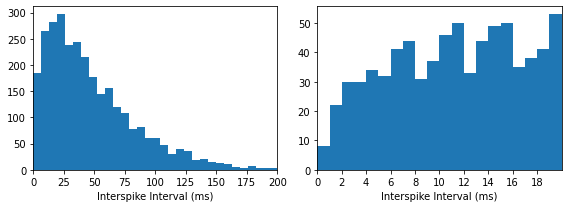

In [14]:
from bmtk.utils.reports.spike_trains import GammaSpikeGenerator

gsg = GammaSpikeGenerator(population='test', seed=100)
gsg.add(node_ids=nodes, firing_rate=20.0, a=1.5, times=(start_time, end_time))
plot_isi(gsg)

In [15]:
gsg.to_dataframe()

,node_ids,timestamps,population
0,0,3.785552,test
1,0,56.363116,test
2,0,142.363613,test
3,0,202.859919,test
4,0,235.317386,test
...,...,...,...
3031,49,2684.862978,test
3032,49,2761.559305,test
3033,49,2787.046196,test
3034,49,2848.763622,test


In [16]:
# Testing exceptions

gsg = GammaSpikeGenerator(population='test', seed=100)
gsg.add(node_ids=nodes, firing_rate=20.0, a=-1.5, times=(start_time, end_time))

ValueError: Shape parameter `a` cannot be negative.

30.0
Actual Firing Rate (Hz): 29.786666666666665


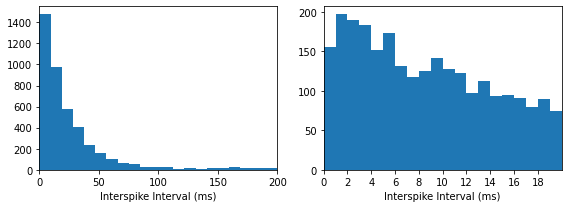

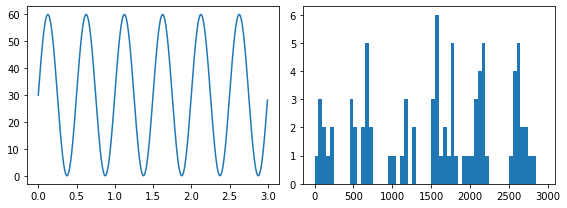

In [24]:
# Test Poisson spike generator inhomogeneous with abs and rel refractory periods

fr_t = np.arange(start_time, end_time, 0.005)
fr_vec = 30+30*np.sin(2*np.pi*2*fr_t)
#fr_vec = 5+2*fr_t**2     # Also checks
print(np.mean(fr_vec))

psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=fr_vec, times=fr_t)
# Added an exception so this is no longer valid:
# psg.add(node_ids=nodes, firing_rate=fr_vec, times=(start_time, end_time))
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

df = psg.to_dataframe()
spk_times = df[df['node_ids']==0]['timestamps']
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(fr_t,fr_vec)
edges = np.arange(0,3000,50)   # 50 ms bins should have on average 50/20 = 2.5 sp/bin
ax[1].hist(spk_times, bins=edges)
fig.tight_layout()

/home/ping/bmtk_change/bmtk/bmtk/utils/reports/spike_trains/spike_trains.py:261: UserWarning: When using refractory periods, the actual firing rates may be less than the desired firing rates, particularly for high rates, and saturates at 1/abs_ref.
  warnings.warn(str)


Actual Firing Rate (Hz): 26.326666666666664


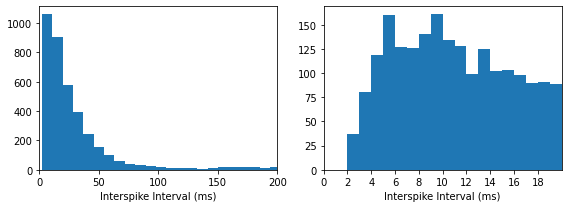

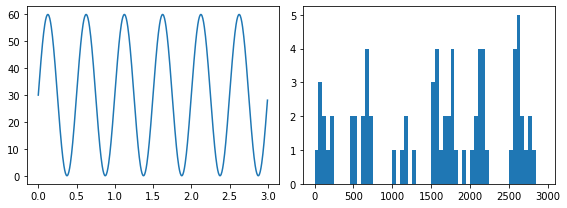

In [25]:
psg = PoissonSpikeGenerator(population='test', seed=200)
psg.add(node_ids=nodes, firing_rate=fr_vec, times=fr_t, abs_ref=0.002, tau_ref=0.003)
plot_isi(psg)

actual_fr = psg.n_spikes()/(end_time-start_time)/len(nodes)
print(f'Actual Firing Rate (Hz): {actual_fr}')

df = psg.to_dataframe()
spk_times = df[df['node_ids']==0]['timestamps']
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(fr_t,fr_vec)
edges = np.arange(0,3000,50)   # 50 ms bins should have on average 50/20 = 2.5 sp/bin
ax[1].hist(spk_times, bins=edges)
fig.tight_layout()

In [26]:
# Tests
import numpy as np
from matplotlib import pyplot as plt

lam = 110/1000
tau_ref = 3
abs_ref = 2
t = np.arange(0,300,1)
f1 = sum(lam*np.exp(-lam*t)*t)
f2 = sum((1-np.exp(-t/tau_ref))*lam*np.exp(-lam*t)*t)
f3 = sum(np.exp(-t/tau_ref)*lam*np.exp(-lam*t)*t)
t2 = np.arange(abs_ref, 500,1)
f4 = sum((1-np.exp(-(t2-abs_ref)/tau_ref))*lam*np.exp(-lam*t2)*t2)
f5 = sum((1-np.exp(-(t2-abs_ref)/tau_ref))*lam*np.exp(-lam*t2))

f11 = sum(lam*np.exp(-lam*t))
f12 = sum((1-np.exp(-t/tau_ref))*lam*np.exp(-lam*t))

A = tau_ref/(lam*tau_ref+1)

f13 = sum((1-np.exp(-t/tau_ref))*lam*np.exp(-lam*t)/(1-A))
f3
1/lam-lam*(A**2)

f12
(1-lam*A)
f4/f5

13.392536994825823

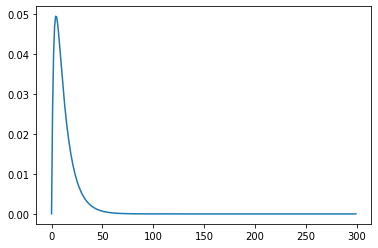

In [21]:
del y
y = lam*(1-np.exp(-t/tau_ref))*np.exp(-lam*t)
plt.plot(t,y)

In [18]:
from scipy.optimize import fsolve
import numpy as np
from matplotlib import pyplot as plt

abs_ref = 2
tau_ref = 3

if tau_ref != 0:
    def f(fr_new, abs_ref, tau_ref, fr):
        return (np.exp(-fr_new * abs_ref) - \
                fr_new * np.exp(abs_ref / tau_ref) * tau_ref /
                (fr_new * tau_ref + 1) * \
                (np.exp(-(fr_new + 1 / tau_ref) * abs_ref))) * fr_new - fr
else:
    def f(fr_new, abs_ref=abs_ref, fr=fr):
        return np.exp(-fr_new * abs_ref) * fr_new - fr

fr_set = np.logspace(0.1,2.8,20)/1000
fr_new_set = np.empty(fr_set.shape)
for i, fr in enumerate(fr_set):
    fr_new_set[i] = fsolve(f, fr, args=(abs_ref, tau_ref, fr))


/home/ping/venv/bmtk_env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


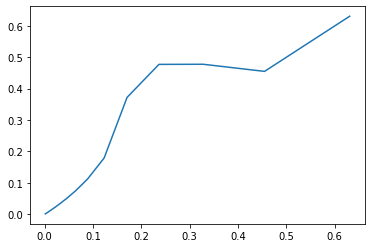

In [11]:
plt.plot(fr_set, fr_new_set)

Max firing rate: 86.76851278554221


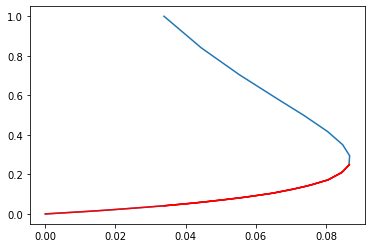

In [56]:
abs_ref = 2
tau_ref = 3

if tau_ref!=0:
    def f2(fr_new, abs_ref=abs_ref, tau_ref=tau_ref):
        return (np.exp(-fr_new * abs_ref) - \
            fr_new * np.exp(abs_ref / tau_ref) * tau_ref /
            (fr_new * tau_ref + 1) * \
            (np.exp(-(fr_new + 1 / tau_ref) * abs_ref))) * fr_new

else:
    def f2(fr_before, abs_ref=abs_ref):
        return np.exp(-fr_before * abs_ref) * fr_before

fr_new_set = np.logspace(-3,3,80)/1000
#fr_new_set = np.linspace(0,500,40)/1000
fr_set = f2(fr_new_set)

plt.plot(fr_set, fr_new_set)

max_fr = np.max(fr_set)
print('Max firing rate:', max_fr*1000)
max_ind = np.argmax(fr_set)

z = np.polyfit(fr_set[:max_ind], fr_new_set[:max_ind], 10)
p = np.poly1d(z)

plt.gca().plot(fr_set, p(fr_set),'r-')

In [27]:
from scipy.optimize import fsolve

# lam_star is the lambda value that should result in the desired lambda after removal of spikes within the refractory period

def f(lam_star, abs_ref=0.002, lam=100):
    return np.exp(-lam_star*abs_ref)*lam_star-lam

a = fsolve(f,lam)
print(a)
print(f(a))
(-np.exp(-100*0.002))


[129.58555091]
[0.]


-0.8187307530779818

In [ ]:
lam = 110
abs_ref = 0.002
tau_ref = 0.003

a = (1-np.exp(-lam*abs_ref)) 
b = lam*np.exp(abs_ref/tau_ref)*tau_ref/(lam*tau_ref+1)*(np.exp(-(lam+1/tau_ref)*abs_ref))

print(a)
print(b)
print(1-(a+b))
print((1-(a+b))*lam)

In [ ]:
fr = 50.0
abs_ref = 0.002
tau_ref = 0.003

def f(fr_new, abs_ref=abs_ref, tau_ref = tau_ref, fr=fr):
    return (np.exp(-fr_new * abs_ref) - \
            fr_new * np.exp(abs_ref / tau_ref) * tau_ref /
            (fr_new * tau_ref + 1) * \
            (np.exp(-(fr_new + 1 / tau_ref) * abs_ref))) * fr_new - fr

#x = np.array([0.0, fr])
a = fsolve(f,fr)

In [ ]:
i = np.random.random(100)
et = np.mean(i)
print(1/et)

total_time = sum(i)
print(100/total_time)

In [ ]:
from sympy.solvers import solve
from sympy import Symbol
from sympy import exp

lam_star = Symbol('lam_star')

#solve(exp(-lam_star*abs_ref)*lam_star-lam, lam_star)    # Does not return

solve(exp(lam_star)-1, lam_star)

In [ ]:
from sympy import *

A = symbols('A')
simplify((1/lam-lam*A**2)/(1-A))

In [ ]:
t = Symbol('t')
integrate((1-exp(-(t-abs_ref)/tau_ref))*lam*exp(-lam*t), (t, abs_ref, oo))

In [ ]:
integrate((1-exp(-(t-abs_ref)/tau_ref))*lam*exp(-lam*t)*t, (t, abs_ref, oo))